# Attention maps visualization

the objective is to visualize the attention maps for the different values of the regularization parameter

In [1]:
# preparation of the environment
%load_ext autoreload
%autoreload 2

import os
from os import path
# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)

import pandas as pd
import numpy as np
import torch
from training_bert import BertNliLight
from regularize_training_bert import SNLIDataModule
from regularize_training_bert import BertNliRegu
from torch.utils.data import DataLoader

# --> from this environment
from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.attention_metrics import normalize_attention

## The models for the study

In [2]:
# the different models
models_dict = {}
for r in [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.08, 0.1, 0.4]:
    model = None
    if r==0:
        ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
        model = BertNliLight.load_from_checkpoint(ckp)
    else :
        ckp = path.join(".cache", "logs", "igrida_trained", f"reg_mul={r}", "best.ckpt")
        model = BertNliRegu.load_from_checkpoint(ckp)
    models_dict[f"reg_mul={r}"] = model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bi

## The HTML table for the visualization

In [ ]:
data_dir = os.path.join(".cache", "raw_data", "e_snli")

dm = SNLIDataModule(cache=data_dir,
                   batch_size = 1,
                   num_workers = 4,
                   nb_data = -1)

dm.prepare_data()

dm.setup(stage="test")

test_dataset = dm.test_set
test_dataloader = dm.test_dataloader()

In [4]:
from attention_algorithms.plausibility_visu import hightlight_txt # function to highlight the text
from attention_algorithms.attention_metrics import normalize_attention
from IPython.display import display, HTML

In [5]:
def html_render(model_outputs):
    html = ''
    table_len = len(model_outputs['GROUNDTRUTH']['Entropy'])
    for i in range(table_len):
        html += '<table>'
        html += '<tr><th></th>' # One xtra head for model's name
        for column_name in model_outputs['GROUNDTRUTH'].keys():
            html+= '<th>'+ column_name +'</th>'
        html += ' </tr>'
        for name, model_content in model_outputs.items():
            html += '<tr>'
            html += '<td><b>' + name + '</b></td>'

            for k, output in model_content.items():
                displ = output[i] if output is not None else 'N/A'
                if isinstance(displ, float):
                    displ = str(round(displ, 3))
                html += '<td>' + displ + '</td>'

            html += '</tr>'

        html += '</table>'
    return html

## The visualization of the different maps -- Look at the layer 3 (different head)

The objective is to observe how the different heads are evolving as mesure as we got a regularize multiplier high

In [14]:
INF = 1e30

with torch.no_grad():   
    for id_batch, elem in enumerate(test_dataloader) :

        if id_batch > 0:
            # only look at 5 sentences (batch of one here)
            break
        
        # elements of the batch
        ids = elem["input_ids"]
        masks = elem["attention_masks"]
        labels = elem["labels"]
        a_true = list(np.array(elem["annotations"][0].numpy(), dtype=float))
        
        # where we have special tokens
        spe_tok_mask = torch.isin(ids, torch.tensor([0, 101, 102])).type(torch.uint8)[0]
        
        for h in range(12):
            
            # for every head we display a table
            model_outputs = {}
            it = 0
            
            display(HTML(f"<h4>Head {h}</h4>"))
            
            for model_name in models_dict:
                # the attention_inst
                raw_attention_inst = RawAttention(model = models_dict[model_name],
                                                 input_ids = ids,
                                                 attention_mask = masks,
                                                 test_mod = False
                                                 )
                if it == 0:
                    model_outputs["GROUNDTRUTH"] = {
                        '[CLS] + P + [SEP] + H + [SEP]':  [hightlight_txt(tokens = raw_attention_inst.tokens,
                                                                        attention = a_true[0 : len(raw_attention_inst.tokens)])],
                        'Entropy': [0.0]
                    }

                    it += 1

                a_hat = raw_attention_inst.attention_tensor[0, 2, h, :, :].sum(dim=0)
                a_hat = torch.softmax(a_hat - INF * spe_tok_mask[0:len(raw_attention_inst.tokens)], dim=0)
                
                a_visu = normalize_attention(attention=a_hat, tokens=raw_attention_inst.tokens)

                model_outputs[model_name] =  {
                    '[CLS] + P + [SEP] + H + [SEP]': [hightlight_txt(tokens = raw_attention_inst.tokens,
                                                                    attention = a_visu)],
                    'Entropy': [(-a_hat * torch.log(a_hat + 1e-16 * spe_tok_mask[0:len(raw_attention_inst.tokens)])).sum().item()]
                }

            display(HTML(html_render(model_outputs)))

,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.306
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.322
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.316
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.263
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.313
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.314
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.218
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.32
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.111


,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.242
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.18
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.144
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.207
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.233
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.178
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.039
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.245
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.189


,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.273
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.222
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.088
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.061
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.244
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.073
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.143
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.281
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.267


,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.274
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.169
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.167
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.177
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.244
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.161
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.015
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.106
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.269


,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.304
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.272
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.217
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.224
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.186
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.167
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.237
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.302
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.296


,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.284
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.203
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.258
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.108
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.223
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.257
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.034
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.256
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.239


,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.153
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.294
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.262
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.282
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.271
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.279
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.265
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.235
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.226


,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.302
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.255
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.211
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.215
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.27
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.193
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.17
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.281
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.281


,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.247
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.214
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.115
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],2.964
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.11
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.127
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.026
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.262
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.303


,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.301
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.284
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.311
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.276
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.314
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.311
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.302
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.311
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.219


,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],2.59
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],2.941
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.035
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],2.9
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.169
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.207
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],1.598
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],2.987
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],2.632


,[CLS] + P + [SEP] + H + [SEP],Entropy
GROUNDTRUTH,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],0.0
reg_mul=0,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.19
reg_mul=0.001,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.234
reg_mul=0.002,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.193
reg_mul=0.003,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],2.978
reg_mul=0.004,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.087
reg_mul=0.005,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],2.979
reg_mul=0.08,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],2.967
reg_mul=0.1,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.167
reg_mul=0.4,[CLS] this church choir sings to the masses as they sing joy ##ous songs from the book at a church . [SEP] the church has cracks in the ceiling . [SEP],3.216


## Entropy map for the layer 3 for the different models (check if the regularization is working well)

In [3]:
data_dir = os.path.join(".cache", "raw_data", "e_snli")
dm = SNLIDataModule(cache=data_dir,
                   batch_size = 4,
                   num_workers = 4,
                   nb_data = 999)
dm.prepare_data()
dm.setup(stage="test")
test_dataset = dm.test_set
test_dataloader = dm.test_dataloader()

In [22]:
INF = 1e30
from torch_set_up import DEVICE # import cuda
from tqdm.notebook import tqdm

with torch.no_grad():
    entropy_map = np.zeros((len(models_dict.keys()), 12))
    for id_model, model_name in enumerate(models_dict):
        model = models_dict[model_name].to(DEVICE)
        for id_batch, batch in tqdm(enumerate(test_dataloader), total=int(999/4)):
            ids = batch["input_ids"].to(DEVICE)
            masks = batch["attention_masks"].to(DEVICE)
            target = torch.tensor([0, 101, 102]).to(DEVICE)
            spe_tok_mask = torch.isin(ids, target).type(torch.uint8)[0].to(DEVICE)
            
            output = model(input_ids = ids,
                          attention_mask = masks)
            
            attention = output["outputs"].attentions[2].to(DEVICE).sum(dim=2) # sum over the lines
            
            # apply the softmax function
            a_hat = torch.softmax(attention - INF*spe_tok_mask, dim=-1)
            entropy = (-a_hat*torch.log(a_hat + 1e-16)).sum(dim=-1).sum(dim=0)
            entropy_map[id_model, :] += entropy.cpu().numpy()
            
            # free the memory
            del ids, masks, spe_tok_mask, attention, a_hat, entropy, target
            
        model = model.cpu()
        del model
        torch.cuda.empty_cache()
        
torch.cuda.empty_cache()

print("state of the DEVICE : ")
print("\t", torch.cuda.get_device_name(0))
print('\t Memory Usage:')
print('\t Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
print('\t Cached:   ', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

	 state of the DEVICE
	 NVIDIA GeForce RTX 3050 Laptop GPU
	 Memory Usage:
	 Allocated: 0.1 GB
	 Cached:    0.4 GB


In [23]:
entropy_map /= 999

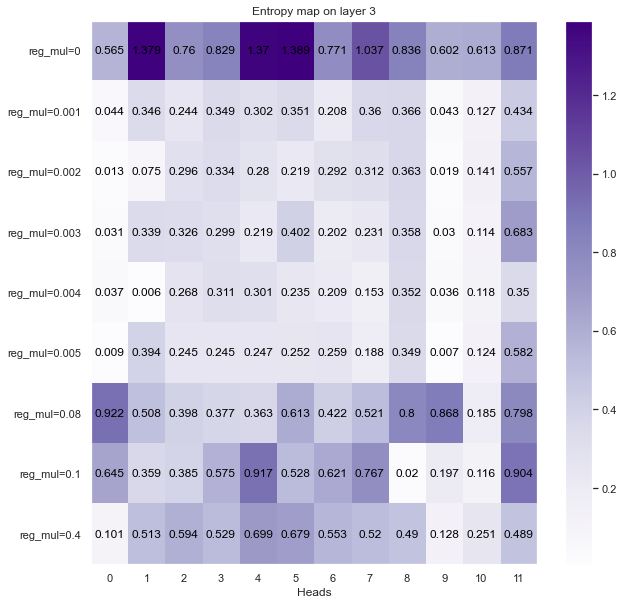

In [29]:
from attention_algorithms.attention_metrics import default_plot_colormap

fig = default_plot_colormap(map = entropy_map,
                           xlabel = "Heads",
                           ylabel = "",
                            title = "Entropy map on layer 3",
                            ystick=list(models_dict.keys())
                        )

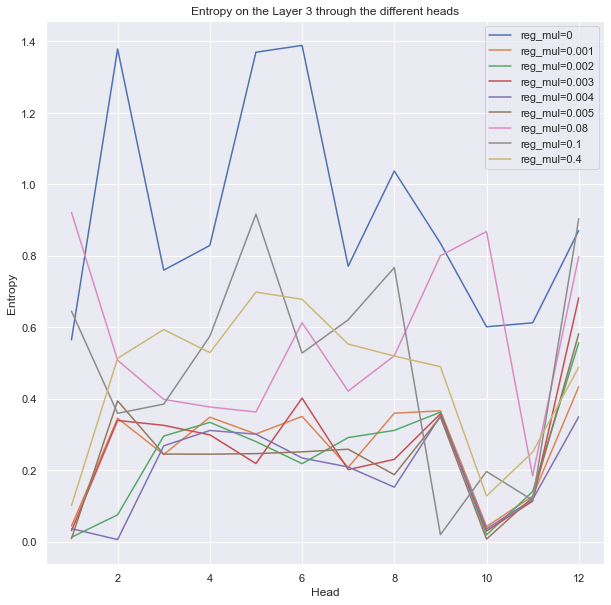

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
plt.ylabel("Entropy")
plt.xlabel("Head")

for i in range(entropy_map.shape[0]):
    plt.plot(list(range(1,13)), entropy_map[i, :], label=list(models_dict.keys())[i])
    
txt = plt.legend()
txt = plt.title("Entropy on the Layer 3 through the different heads")

plt.savefig(os.path.join(".cache", "plots", "entropy_study", "entropy_through_layers.png"))